In [2]:
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from concurrent.futures import ProcessPoolExecutor, as_completed

In [3]:
cpu = 40

In [4]:
def calculate_node_portion(sub_df):
    nodes_records = {}
    for k, v in node_cluster_dict.items():
        left = v['left']
        right = v['right']

        # left hypo, right hyper
        judge_from_left = sub_df['cluster_from'].apply(lambda i: i in left)
        judge_to_right = sub_df['cluster_to'].apply(lambda i: i in right)

        # right hypo, left hyper
        judge_from_right = sub_df['cluster_from'].apply(lambda i: i in right)
        judge_to_left = sub_df['cluster_to'].apply(lambda i: i in left)

        # this two cancel each other, use the remaining abs as real hits
        # positive means left hypo, negative means right hypo
        total = (judge_from_left & judge_to_right).sum() -\
                (judge_from_right & judge_to_left).sum()
        nodes_records[k] = total
    nodes_records = pd.Series(nodes_records) / node_possible_count
    return nodes_records

In [5]:
node_cluster_dict = joblib.load(
    '/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/RTree/Exc.non_singleton_node_dict.lib'
)
related_dmg = pd.read_msgpack('RelatedDMG.msg')

gene_meta = pd.read_csv(
    '/home/hanliu/ref/mouse/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz',
    sep='\t',
    index_col='gene_id')
gene_name_to_id = {v: k for k, v in gene_meta['gene_name'].items()}

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
node_possible_count = {}
for node, sub_dict in node_cluster_dict.items():
    possible_pairs = len(sub_dict['left']) * len(sub_dict['right'])
    node_possible_count[node] = possible_pairs
node_possible_count = pd.Series(node_possible_count)

In [7]:
total_result = {}
with ProcessPoolExecutor(cpu) as executor:
    futures = {}
    for gene, sub_df in related_dmg.groupby('gene_id'):
        future = executor.submit(calculate_node_portion, sub_df)
        futures[future] = gene
        
    for future in as_completed(futures):
        result = future.result()
        gene = futures[future]
        total_result[gene] = result
total_result = pd.DataFrame(total_result)

In [11]:
mask_cutoff = 0.3

masked_result = total_result.copy()
masked_result[masked_result.abs() < 0.3] = 0

In [14]:
# gene that assign to at least one node
((masked_result != 0).sum(axis=0) != 0).sum()

9215

In [18]:
# node that has at least 5 genes
((masked_result != 0).sum(axis=1) > 5).sum()

67

In [50]:
masked_result['ENSMUSG00000018040.9'].describe()

count    67.000000
mean     -0.004664
std       0.038178
min      -0.312500
25%       0.000000
50%       0.000000
75%       0.000000
max       0.000000
Name: ENSMUSG00000018040.9, dtype: float64

In [51]:
masked_result.apply(lambda i: 0 if i.abs().max() == 0 else i.abs().idxmax(), axis=0)

ENSMUSG00000018040.9     128
ENSMUSG00000006456.10    114
ENSMUSG00000004233.14    118
ENSMUSG00000003617.16    128
ENSMUSG00000018651.14    112
                        ... 
ENSMUSG00000118392.1       0
ENSMUSG00000118361.1       0
ENSMUSG00000118454.1       0
ENSMUSG00000118401.1       0
ENSMUSG00000118486.1     111
Length: 19448, dtype: int64

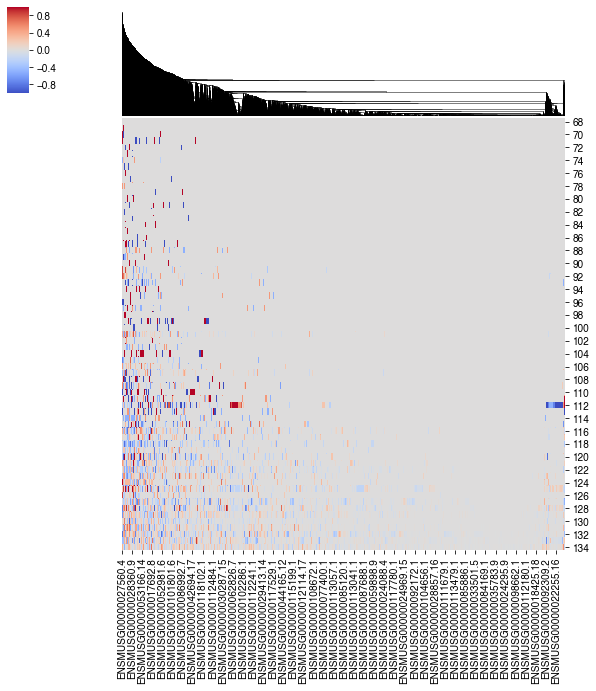

In [22]:
sns.clustermap(total_result, row_cluster=False, cmap='coolwarm')

In [23]:
total_result.to_msgpack('NodeGeneResults.msg')

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  """Entry point for launching an IPython kernel.
